# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm
import re


In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
# Examine few rows
df_reviews.sample(7)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
10609,tt0069019,movie,Don't Torture a Duckling,Non si sevizia un paperino,1972,\N,105,0,"Horror,Mystery,Thriller",7.1,7695,"Easily Lucio Fulci's most respected film, ""Don...",9,pos,1,test,4448
32892,tt0103002,video,Subspecies,Subspecies,1991,\N,90,0,"Fantasy,Horror",5.7,3209,King Vladislav (Angus Scrimm) of Romania is a ...,7,pos,1,test,8701
37467,tt0459387,movie,The Great Ecstasy of Robert Carmichael,The Great Ecstasy of Robert Carmichael,2005,\N,96,0,"Crime,Drama",4.8,1231,Thomas Clay has been mixing with the wrong typ...,1,neg,0,train,6206
20356,tt0165621,movie,Les amazones du temple d'or,Les amazones du temple d'or,1986,\N,86,0,Adventure,3.8,319,. . . and that is only if you like the sight o...,4,neg,0,test,11325
9474,tt0165214,movie,Death Promise,Death Promise,1977,\N,95,0,Action,4.8,306,First time I ever saw this was at a friends ho...,10,pos,1,test,11191
20475,tt0107413,movie,Life with Mikey,Life with Mikey,1993,\N,91,0,"Comedy,Family",5.6,5283,This isn't a bad movie. It's fun to watch for ...,3,neg,0,test,6338
30278,tt0220034,movie,Seven and a Match,Seven and a Match,2001,\N,\N,0,"Comedy,Drama,Romance",6.6,273,"The main character is a whiny, irresponsible s...",1,neg,0,test,5707


## EDA

In [7]:
# Get general information
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
# There are only two missing values each in columns `average_rating` and `votes`.
# Remove missing values

df_reviews = df_reviews.dropna()

In [10]:
# confirm changes
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [11]:
# I think the Dtype of the column `end_year` is not correct. It should be int64. 
# There are lots of \N values in column. It should be changed to NaN values
# Before that I want to know which column have \N values

columns_with_N = [one_col 
                  for one_col in df_reviews.columns 
                  if (df_reviews[one_col] == r'\N').any()]

columns_with_N


['end_year', 'runtime_minutes', 'genres']

There are three columns that have \N values. I will replace with NaN.

In [12]:
# Replace '\N' with NaN
df_reviews = df_reviews.replace(r'\N', np.nan)

In [13]:
df_reviews.isnull().sum()

tconst                 0
title_type             0
primary_title          0
original_title         0
start_year             0
end_year           45050
runtime_minutes      486
is_adult               0
genres                24
average_rating         0
votes                  0
review                 0
rating                 0
sp                     0
pos                    0
ds_part                0
idx                    0
dtype: int64

I will replace the missing values in the `generes` column with 'Unknown'. For missing values in the `runtime_minutes` column, I will fill with the median. I will remove the column `end_year` as it contains many missing values.

In [15]:
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

median_runtime = df_reviews['runtime_minutes'].median()
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].fillna(median_runtime)

# Convert `runtime_minutes` column into 'Int64'.
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype('Int64')

In [16]:
# genres: Fill with 'Unknown'
df_reviews['genres'] = df_reviews['genres'].fillna('Unknown')

In [17]:
#Drop the end_year column due to excessive missing values

df_reviews = df_reviews.drop(columns=['end_year'])

In [18]:
# Confirm changes
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [19]:
# Get general information
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   runtime_minutes  47329 non-null  Int64  
 6   is_adult         47329 non-null  int64  
 7   genres           47329 non-null  object 
 8   average_rating   47329 non-null  float64
 9   votes            47329 non-null  Int64  
 10  review           47329 non-null  object 
 11  rating           47329 non-null  int64  
 12  sp               47329 non-null  object 
 13  pos              47329 non-null  int64  
 14  ds_part          47329 non-null  object 
 15  idx              47329 non-null  int64  
dtypes: Int64(2), float64(1), int64(5), object(8)
memory usage: 6.2+

In [21]:
# Check duplicates
print(df_reviews.duplicated().sum())

0


In [22]:
# Get summary statistics
df_reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
start_year,47329.0,1989.630882,19.600702,1894.0,1982.0,1998.0,2004.0,2010.0
runtime_minutes,47329.0,98.721122,38.127183,1.0,87.0,95.0,109.0,1140.0
is_adult,47329.0,0.001733,0.041588,0.0,0.0,0.0,0.0,1.0
average_rating,47329.0,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7
votes,47329.0,25562.917323,83670.039163,9.0,827.0,3197.0,13974.0,1739448.0
rating,47329.0,5.484439,3.473083,1.0,2.0,4.0,9.0,10.0
pos,47329.0,0.498933,0.500004,0.0,0.0,0.0,1.0,1.0
idx,47329.0,6279.826808,3605.72428,0.0,3162.0,6300.0,9412.0,12499.0


Let's check the number of movies and reviews over years.

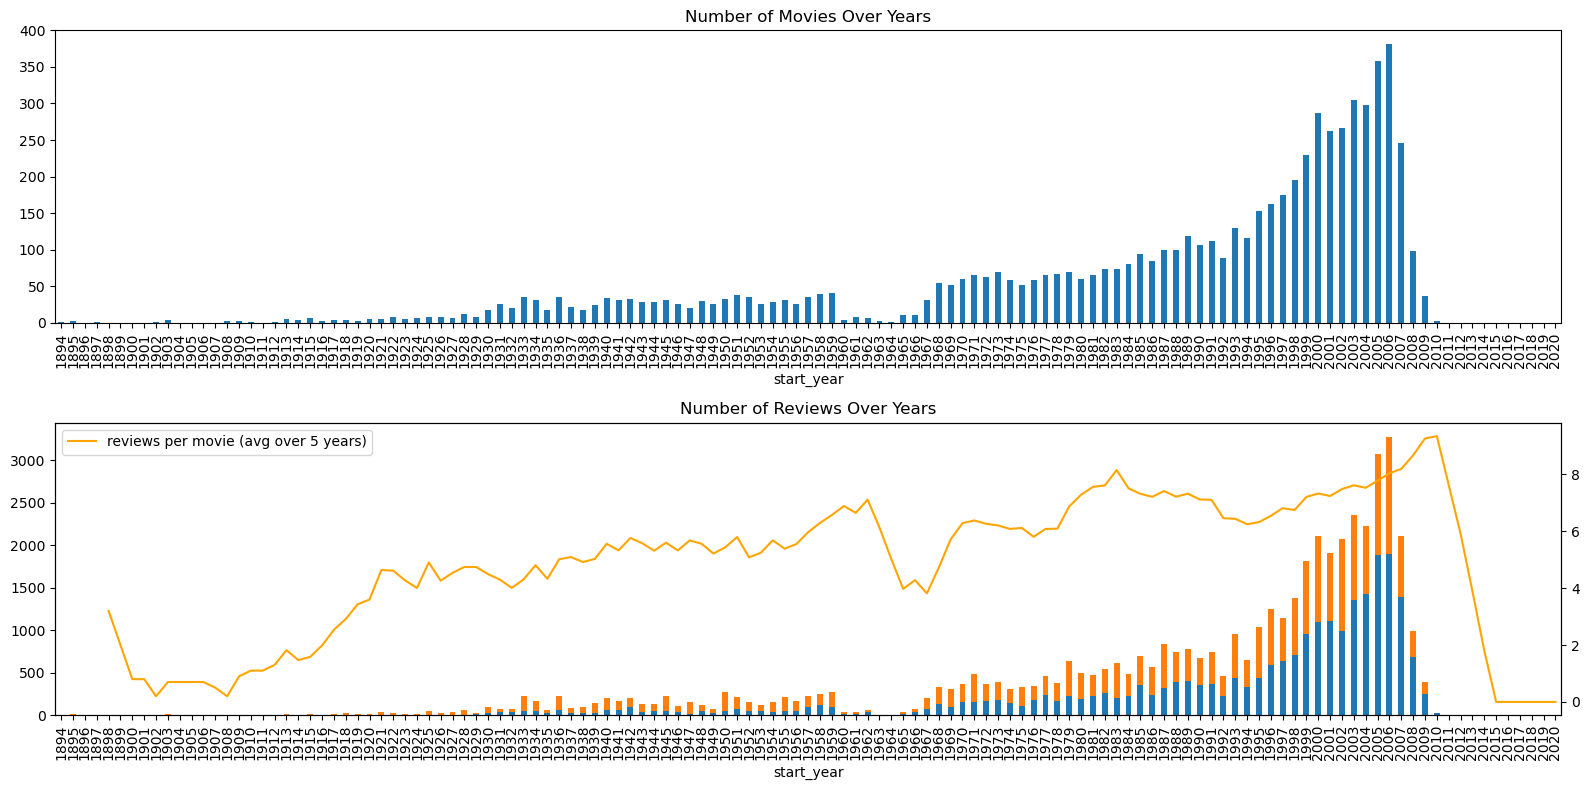

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In the early days, there were fewer movies released.The momentum picked up in the early 30s and continued until the late 50s. However, the trend seems a bit stationary. Afterward, there was a sharp decrease until the mid 60s. Then the momentum picked up and there was a slight increase over time. It peaked in 2006 and then started to decrease.

Movie reviews overall remained relatively stable except in the 1900s and early 60s. we can see a steady increase in the number of movies. The average number of reviews also increases.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

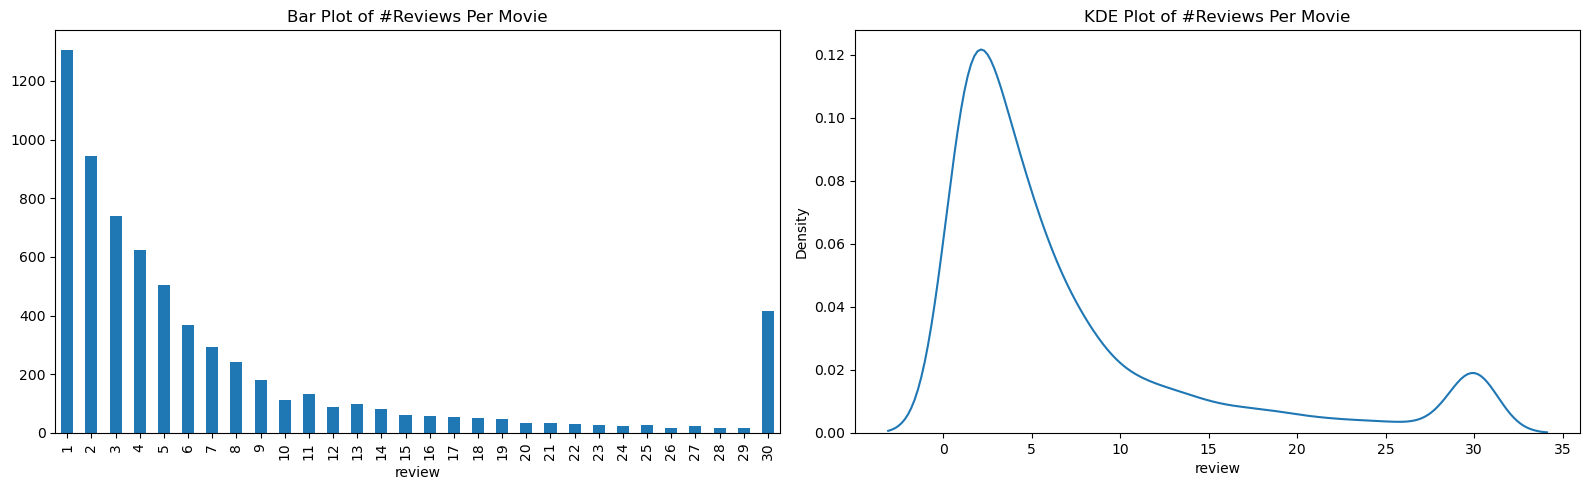

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most movies have only one review. The distribution is skewed to the right. It means there are fewer movies that received more reviews.

In [25]:
# Overview of Sentiment Balance in Movie Reviews
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

We can say that there is nearly balanced distribution of positive and negative reviews.

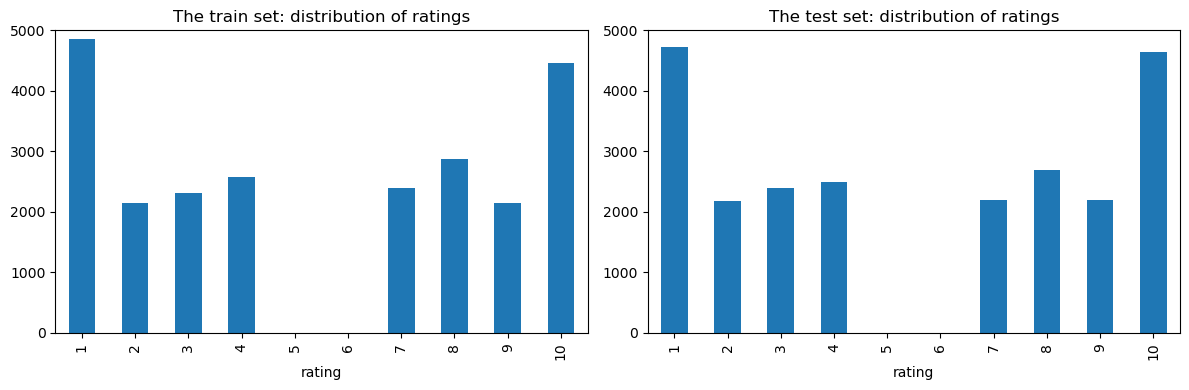

In [26]:
# Comparison of Rating Distributions in Training and Test Sets

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings is almost similar in the train and test sets. It shows that there is no sampling bias.

Distribution of negative and positive reviews over the years for two parts of the dataset.

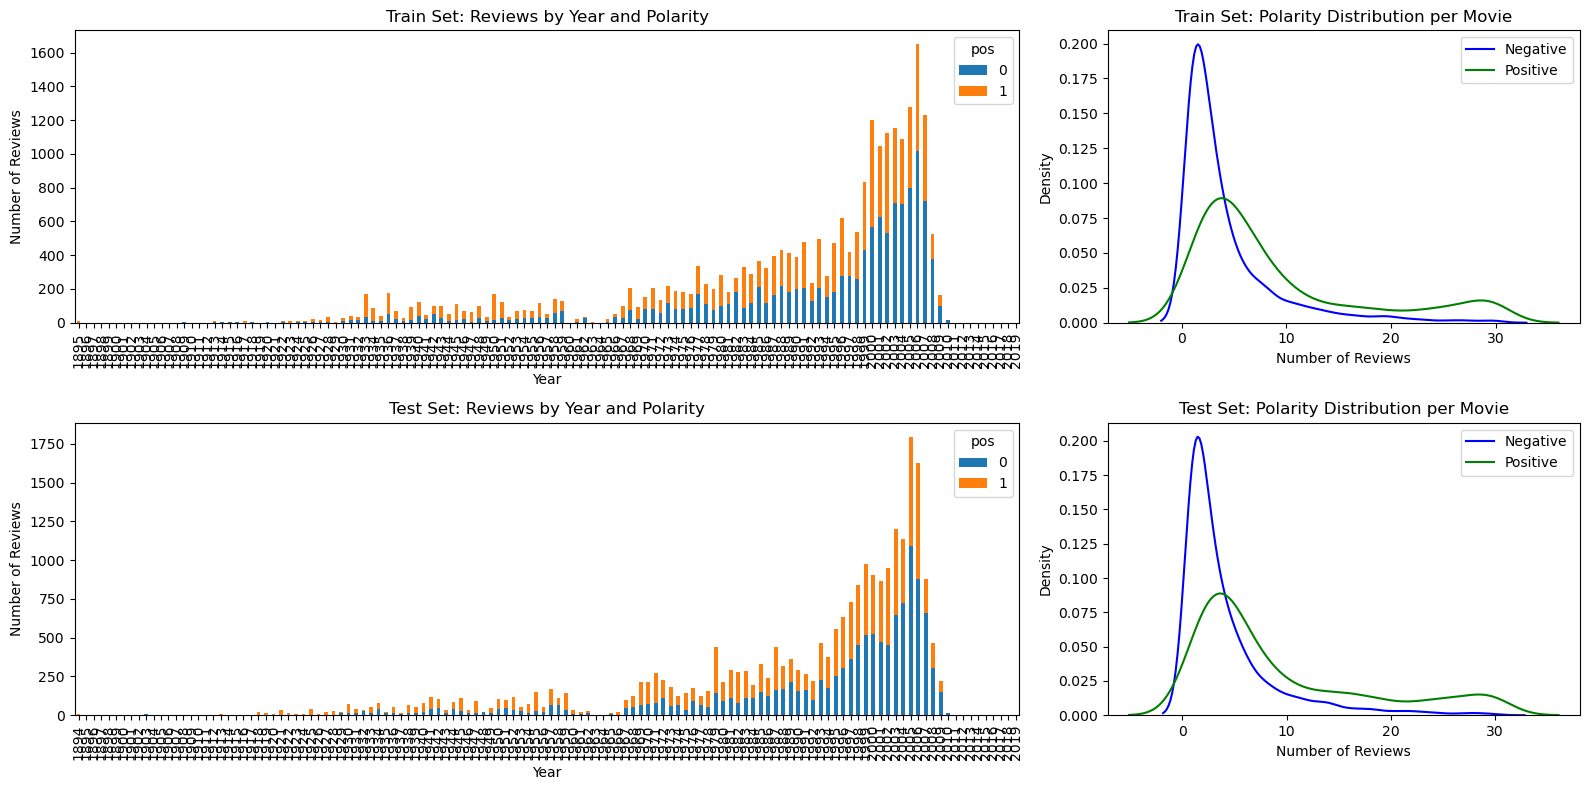

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 subplot grid with custom width and height ratios
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Top-left: Train set - Number of reviews by year and polarity
ax = axs[0, 0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train Set: Reviews by Year and Polarity')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')

# Top-right: Train set - Distribution of polarities per movie
ax = axs[0, 1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='Negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='Positive', ax=ax)
ax.legend()
ax.set_title('Train Set: Polarity Distribution per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Density')

# Bottom-left: Test set - Number of reviews by year and polarity
ax = axs[1, 0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test Set: Reviews by Year and Polarity')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')

# Bottom-right: Test set - Distribution of polarities per movie
ax = axs[1, 1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='Negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='Positive', ax=ax)
ax.legend()
ax.set_title('Test Set: Polarity Distribution per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Density')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [29]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [30]:
# Define the text cleaning function
def clean_text(text):
    pattern = r'[^a-z\s]' 
    text = re.sub(pattern, '', str(text).lower())  
    text = ' '.join(text.split())
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

In [31]:
#  single normalized review
df_reviews['review_norm'][0]

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats not what i got out of it i didnt get anything in the first half theres a new character without introduction in every other scene the first halfhour is completely incomprehensible the rest is just one long annoying underlit chase scene theres always an irritating sound in the background whether its a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie'

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [32]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23533, 17)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


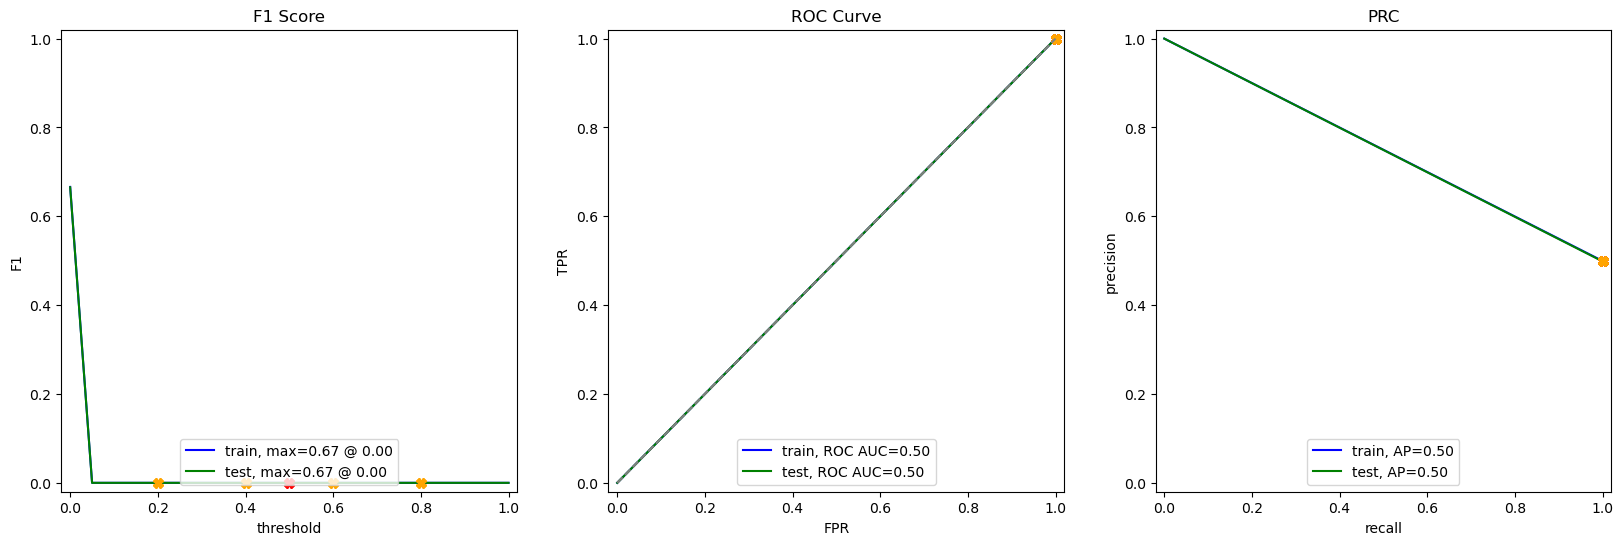

In [34]:
from sklearn.dummy import DummyClassifier

model_0 = DummyClassifier(strategy='most_frequent', random_state=100) 

model_0.fit(df_reviews_train, train_target)

evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)

It is clear that the dummy model is not doing a great job. Our model should aim for an F1 score of at least 0.85.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [35]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashokmaharjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Model 1 - NLTK Stopwords, TF-IDF and Logistic Regression
          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


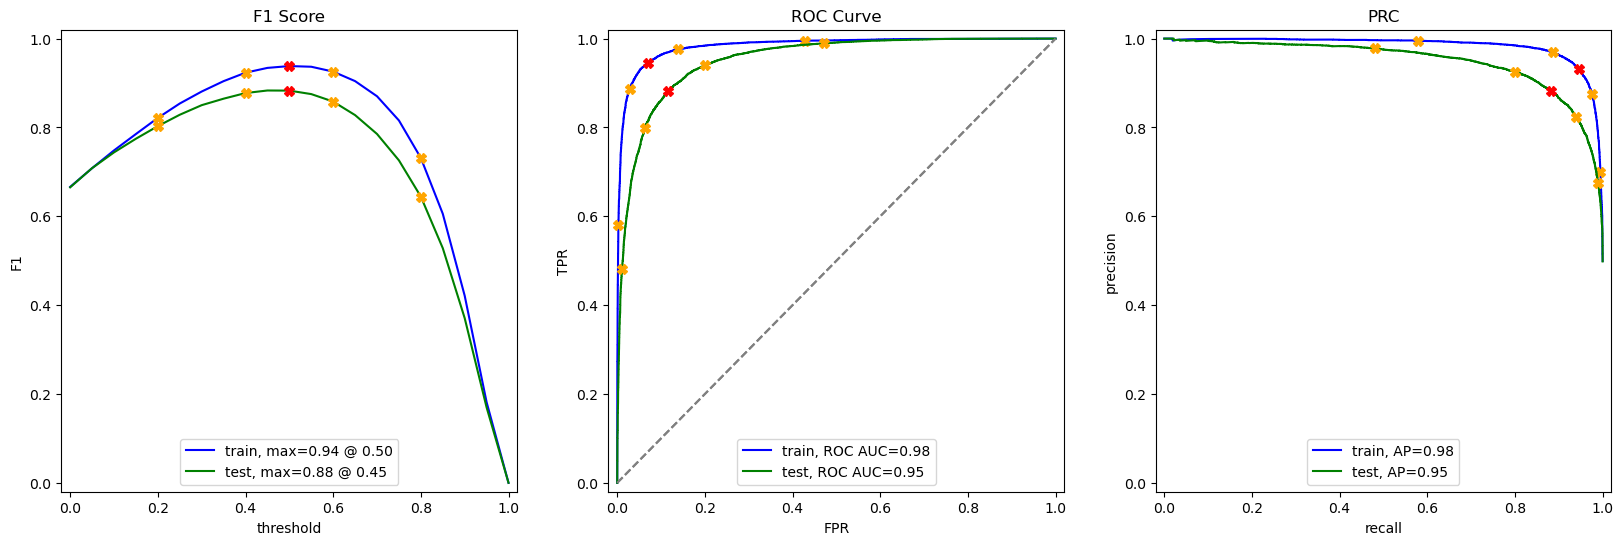

In [36]:
# Download NLTK stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Create TF-IDF vectorizer
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=list(stop_words))

# Fit and transform training data, transform test data
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Initialize and train Logistic Regression
model_1 = LogisticRegression(random_state=100)
model_1.fit(train_features_1, train_target)

# Evaluate model
print("Model 1 - NLTK Stopwords, TF-IDF and Logistic Regression")
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

There is a small gap between the values from the test and train sets, showing that there is not much overfitting. This model is far better than the baseline. With an 88% F1 score and 95% ROC AUC on test data, it will reliably classify sentiment in real-world scenarios.

Model 2 - spaCy, TF-IDF and LR¶

In [37]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

Model 2 - spaCy, TF-IDF and LR
          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


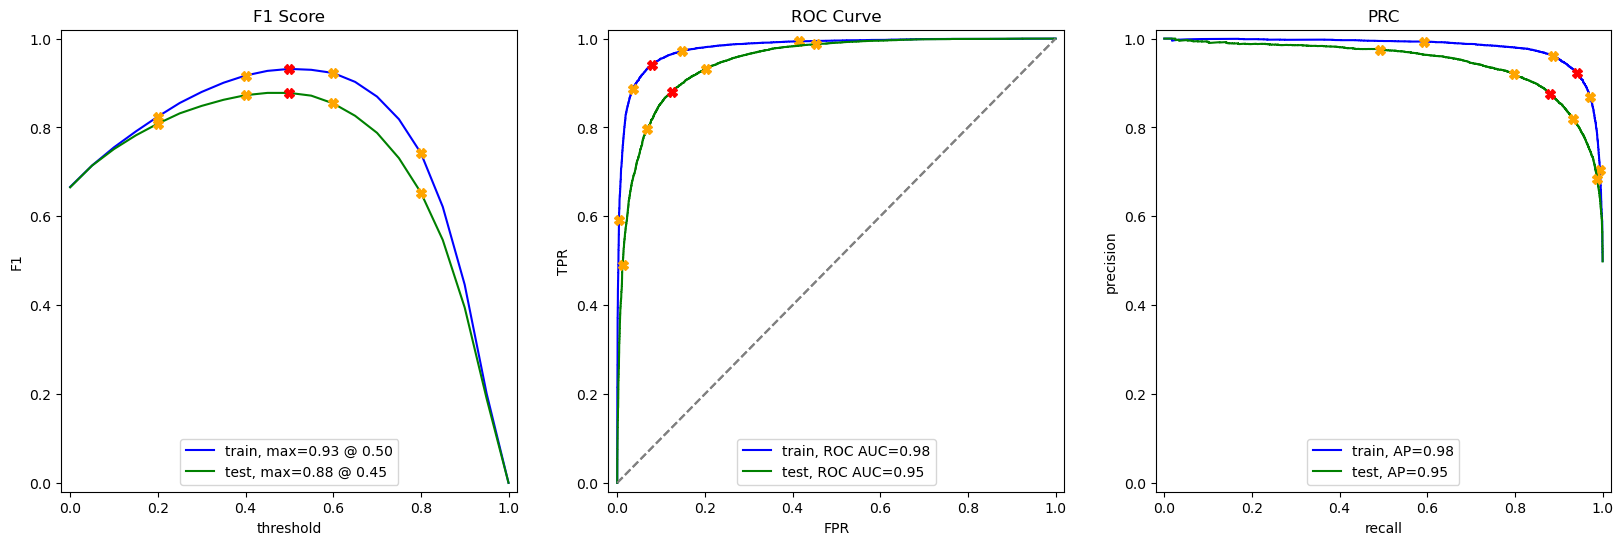

In [39]:

# Apply spaCy preprocessing to review_norm
review_train = df_reviews_train['review_norm'].apply(text_preprocessing_3)
review_test = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Initialize TF-IDF vectorizer with stopwords
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=list(stop_words))

# Transform preprocessed text to TF-IDF features
train_features_2 = tfidf_vectorizer_2.fit_transform(review_train)
test_features_2 = tfidf_vectorizer_2.transform(review_test)

# Initialize and train Logistic Regression
model_2 = LogisticRegression(random_state=100)
model_2.fit(train_features_2, train_target)

# Evaluate model
print("Model 2 - spaCy, TF-IDF and LR")
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)


The model has performed well. The spaCy preprocessing increased computational load but did not improve Model 1. In fact, both models gave the same results on test data.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [40]:
from lightgbm import LGBMClassifier

Model 3 - spaCy, TF-IDF and LGBMClassifier


/Users/ashokmaharjan/miniconda/envs/data_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ashokmaharjan/miniconda/envs/data_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ashokmaharjan/miniconda/envs/data_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ashokmaharjan/miniconda/envs/data_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


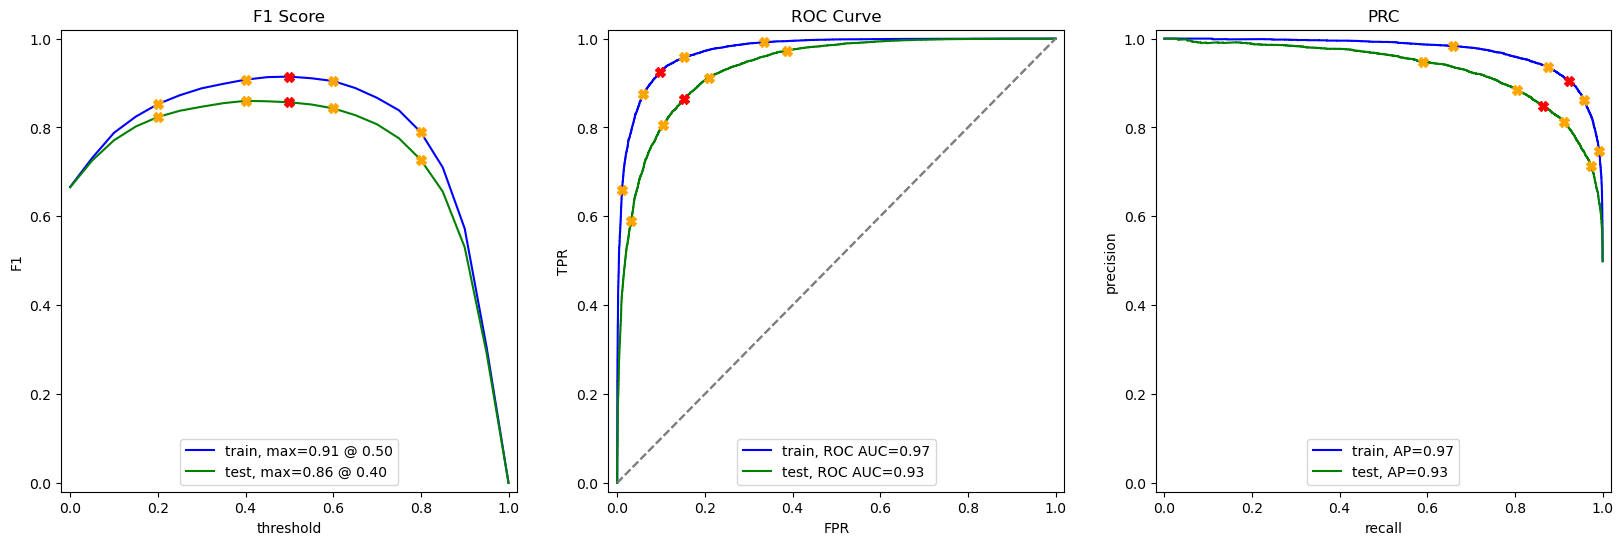

In [41]:
# Initialize TF-IDF vectorizer 
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=list(stop_words))

# Transform preprocessed text to TF-IDF features
train_features_3 = tfidf_vectorizer_3.fit_transform(review_train)
test_features_3 = tfidf_vectorizer_3.transform(review_test)

# Initialize and train LGBMClassifier
model_3 = LGBMClassifier(random_state=100, verbosity=-1)
model_3.fit(train_features_3, train_target)

# Evaluate model
print("Model 3 - spaCy, TF-IDF and LGBMClassifier")
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

The model performed well, but its performance is slightly lower than the previous two models.

## My Reviews

In [42]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 2

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [46]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_3 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.45:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.70:  i didnt expect the reboot to be so good writers really cared about the source material
0.69:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.30:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.77:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Create a summary table to see a big picture on sentiment analysis

In [47]:
import pandas as pd

# Set pandas option to display full text 
pd.set_option('display.max_colwidth', None)

# Data with full reviews
data = {
    'Review': [
        'I did not simply like it, not my kind of movie.',
        'Well, I was bored and felt asleep in the middle of the movie.',
        'I was really fascinated with the movie',
        'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
        'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
        'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
        'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
        'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
    ],
    'Intuitive Sentiment': [
        'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Neutral/Positive', 'Negative', 'Positive'
    ],
    'Model 1 Probability': [0.16, 0.17, 0.57, 0.13, 0.26, 0.48, 0.05, 0.84],
    'Model 2 Probability': [0.20, 0.14, 0.61, 0.13, 0.27, 0.47, 0.03, 0.92],
    'Model 3 Probability': [0.57, 0.45, 0.60, 0.40, 0.70, 0.69, 0.30, 0.77]}

# Create DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame 
results_df

,Review,Intuitive Sentiment,Model 1 Probability,Model 2 Probability,Model 3 Probability
0,"I did not simply like it, not my kind of movie.",Negative,0.16,0.20,0.57
1,"Well, I was bored and felt asleep in the middle of the movie.",Negative,0.17,0.14,0.45
2,I was really fascinated with the movie,Positive,0.57,0.61,0.60
3,"Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",Negative,0.13,0.13,0.40
4,I didn't expect the reboot to be so good! Writers really cared about the source material,Positive,0.26,0.27,0.70
5,"The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",Neutral/Positive,0.48,0.47,0.69
6,"What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",Negative,0.05,0.03,0.30
7,"Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.",Positive,0.84,0.92,0.77


Model 1 and Model 2 align well with the Intuitive Sentiment. So we can say that the Logistic Regression models (Models 1 and 2) significantly outperform LightGBM (Model 3). For example, the review "I did not simply like it, not my kind of movie" clearly shows a negative tone. However, Model 3 gave a probability score of 0.57, which is obviously not correct. On the other hand, Model 1 gave a score of 0.16 and Model 2 gave 0.20, which makes sense given such a negative review.

In [48]:
# Create DataFrame with test 
model_comparison = pd.DataFrame({
    'Model': [
        'Model 0 - Constant (DummyClassifier)',
        'Model 1 - NLTK, TF-IDF and LR', 
        'Model 2 - spaCy, TF-IDF and LR',
        'Model 3 - spaCy, TF-IDF and LGBMClassifier'
    ],
    'Test_Accuracy': [0.50, 0.88, 0.88, 0.86],
    'Test_F1': [0.00, 0.88, 0.88, 0.86],
    'Test_APS': [0.50, 0.95, 0.95, 0.93],
    'Test_ROC_AUC': [0.50, 0.95, 0.95, 0.93]})

# Display the DataFrame
model_comparison

,Model,Test_Accuracy,Test_F1,Test_APS,Test_ROC_AUC
0,Model 0 - Constant (DummyClassifier),0.50,0.00,0.50,0.50
1,"Model 1 - NLTK, TF-IDF and LR",0.88,0.88,0.95,0.95
2,"Model 2 - spaCy, TF-IDF and LR",0.88,0.88,0.95,0.95
3,"Model 3 - spaCy, TF-IDF and LGBMClassifier",0.86,0.86,0.93,0.93


Similarly, both Model 1 and Model 2 have the highest test performance. Both are based on logistic regression. The performance of Model 3 is slightly less than the logistic-based regression. We can say that despite Model 3 being an advanced LGBMClassifier, its efficiency is not on par with logistic regression in this scenario.

## Conclusions

In this project, we tested different models to classify IMDb movie reviews as positive or negative using data from the Film Junky Union. After preprocessing and exploratory data analysis, we observed that the dataset was well-balanced and suitable for classification. All models exceeded the F1 score of 0.85, except the DummyClassifier. Logistic Regression models (Model 1 with NLTK stopwords and Model 2 with spaCy lemmatization) achieved an F1 score of 0.88 and ROC AUC of 0.95. Model 3 (LightGBM), despite being an advanced model, scored slightly lower (F1 = 0.86, ROC AUC = 0.93). When tested on user-written reviews, Logistic Regression models were more reliable for real-world sentiment classification than LightGBM.